In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://www.hs-coburg.de/wp-content/uploads/2024/11/CIDDS-001.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score,classification_report,confusion_matrix
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
import torch

In [4]:
df = pd.read_csv('CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv')

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---


In [6]:
# 미사용 컬럼 제거
df = df.drop(columns = ['Src Pt','Dst Pt','Flows','Tos','class','attackID','attackDescription'])
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,---
...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,---
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,---
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,---
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,---


In [7]:
df['attackType'] = df['attackType'].replace('---','benign')
df['Date first seen'] = pd.to_datetime(df['Date first seen'])

In [8]:
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign
...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,benign
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,benign
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,benign
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,benign


([<matplotlib.patches.Wedge at 0x154c15c30>,
 [Text(-0.9468730251355885, 0.5598495103780831, 'benign'),
  Text(0.9064854364573016, -0.6231245088189162, 'dos'),
  Text(1.0974386808803767, -0.07502227474249756, 'portScan')],
 [Text(-0.5164761955285028, 0.30537246020622705, '83%'),
  Text(0.49444660170398264, -0.3398860957194088, '15%'),
  Text(0.5986029168438418, -0.040921240768635035, '2%')])

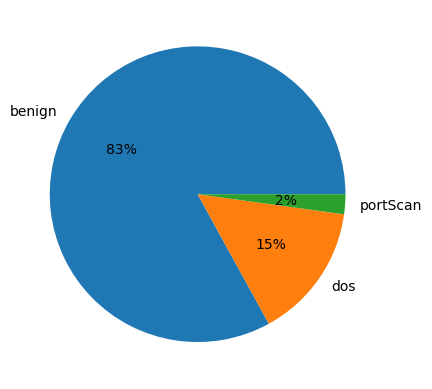

In [ ]:
# 공격 타입 파이차트 시각화
count_labels = df['attackType'].value_counts() / len(df) * 100
top3_labels = df['attackType'].value_counts().index[:3]
plt.pie(count_labels[:3],labels=top3_labels,autopct='%.0f%%')

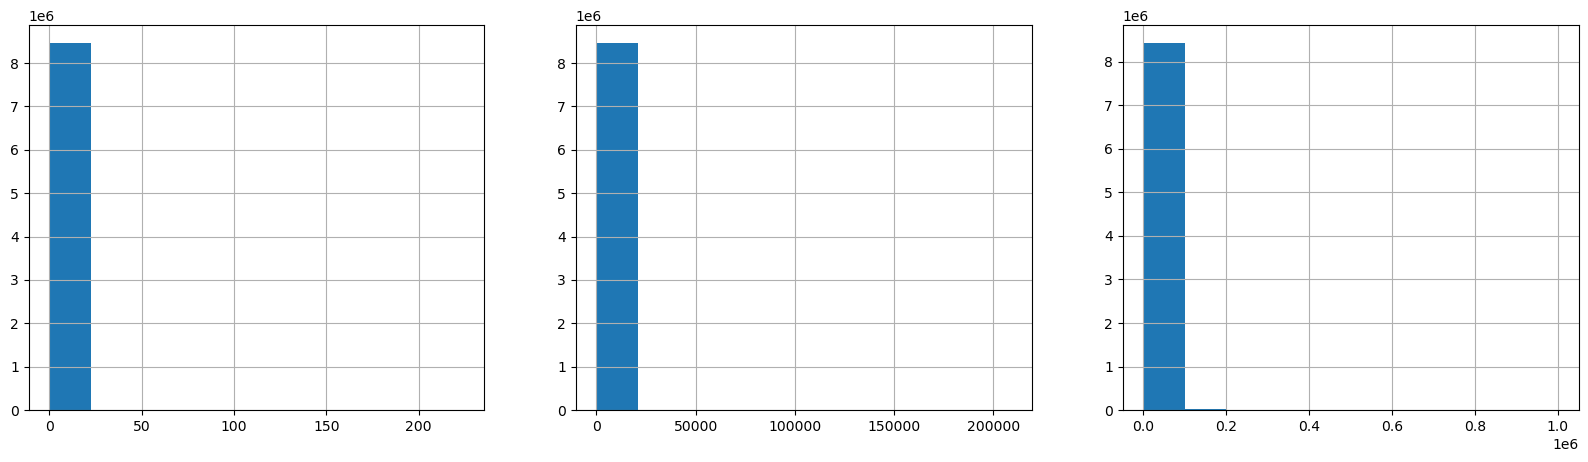

In [ ]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(20,5))
df['Duration'].hist(ax=ax1)
ax1.set_label('Duration')
df['Packets'].hist(ax=ax2)
ax2.set_label('Packets')
pd.to_numeric(df['Bytes'],errors='coerce').hist(ax=ax3) # 변환불가시 NAN 처리
ax3.set_label('Bytes')
plt.show()

전처리

In [ ]:
df['weekday'] = df['Date first seen'].dt.weekday
df = pd.get_dummies(df, columns=['weekday']).rename(columns = {'weekday_0': 'Monday', # 각 요일에 맞게 원핫인코딩
                                                              'weekday_1': 'Tuesday',
                                                              'weekday_2': 'Wednesday',
                                                              'weekday_3': 'Thursday',
                                                              'weekday_4': 'Friday',
                                                              'weekday_5': 'Saturday',
                                                              'weekday_6': 'Sunday',
                                                             })

In [35]:
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,benign,0,1,0,0,0,0,0
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,benign,0,1,0,0,0,0,0
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,benign,0,1,0,0,0,0,0
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,benign,0,1,0,0,0,0,0


In [36]:
df['daytime'] = (df['Date first seen'].dt.second + df['Date first seen'].dt.minute*60 + df['Date first seen'].dt.hour*60*60) / (24*60*60)
# 하루에 대한 초로 정규화( 0 ~ 1 )

In [37]:
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.000880
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.000880
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,benign,0,1,0,0,0,0,0,0.999954
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,benign,0,1,0,0,0,0,0,0.999965
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,benign,0,1,0,0,0,0,0,0.999954
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,benign,0,1,0,0,0,0,0,0.999977


In [39]:
df['Flags'].value_counts()

.A....    2652182
......    1057702
.AP...    1049867
.AP.S.     848656
.AP.SF     834847
.A..SF     638075
.A...F     613708
.AP..F     254596
.A..S.     200000
....S.     114749
.A.R..      82399
...R..      46718
.APR.F      29520
.A.R.F       9743
.APR..       5810
.APRSF       4821
.APRS.       3850
...RS.       3174
.A.RS.        821
.A.RSF        282
Name: Flags, dtype: int64

In [42]:
def one_hot_flags(input):
    return [1 if char1 == char2 else 0 for char1, char2 in zip('APRSF', input[1:])]

In [45]:
df = df.reset_index(drop=True)
ohe_flags = df['Flags'].apply(one_hot_flags).to_list() # 데이터 프레임 모든 행에 각각 함수 적용
df[['ACK','PSH','RST','SYN','FIN']] = pd.DataFrame(ohe_flags,columns =['ACK','PSH','RST','SYN','FIN'])

In [46]:
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,benign,0,1,0,0,0,0,0,0.999954,1,1,0,0,0
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,benign,0,1,0,0,0,0,0,0.999965,1,0,0,0,0
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,benign,0,1,0,0,0,0,0,0.999954,1,0,0,0,0
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,benign,0,1,0,0,0,0,0,0.999977,1,1,0,0,0


In [48]:
temp = pd.DataFrame()
temp['SrcIP'] = df['Src IP Addr'].astype(str)
temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.',regex=True)] = '0.0.0.0' # IP 형식을 벗어나면 0
temp = temp['SrcIP'].str.split('.',expand=True).rename(columns = {2:'ipsrc3', 3:'ipsrc4'}).astype(int)[['ipsrc3','ipsrc4']]
temp['ipsrc'] = temp['ipsrc3'].apply(lambda x: format(x,'b').zfill(8)) + temp['ipsrc4'].apply(lambda x: format(x,'b').zfill(8))

In [53]:
df = df.join(temp['ipsrc'].str.split('',expand=True).drop(columns=[0,17]).rename(columns=dict(enumerate({f'ipsrc_{i}' for i in range(17)}))).astype('int32'))

In [55]:
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_9,ipsrc_10,ipsrc_1,ipsrc_4,ipsrc_16,ipsrc_7,ipsrc_11,ipsrc_3,ipsrc_15,ipsrc_13,ipsrc_5,ipsrc_8,ipsrc_14,ipsrc_2,ipsrc_12,ipsrc_6
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1


In [56]:
temp = pd.DataFrame()
temp['DstIP'] = df['Dst IP Addr'].astype(str)
temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['DstIP'].str.split('.', expand=True).rename(columns = {2: 'ipdst3', 3: 'ipdst4'}).astype(int)[['ipdst3', 'ipdst4']]
temp['ipdst'] = temp['ipdst3'].apply(lambda x: format(x, "b").zfill(8)) \
                + temp['ipdst4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipdst'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipdst_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_9,ipsrc_10,ipsrc_1,ipsrc_4,ipsrc_16,ipsrc_7,ipsrc_11,ipsrc_3,ipsrc_15,ipsrc_13,ipsrc_5,ipsrc_8,ipsrc_14,ipsrc_2,ipsrc_12,ipsrc_6,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1


In [59]:
df['Bytes'].value_counts() # 16.8M 이라는 특성값 문제

      66    2256100
      54     359338
      55     293995
     108     263026
206          236488
             ...   
   44444          1
  16.8 M          1
  601310          1
  100236          1
   94675          1
Name: Bytes, Length: 94131, dtype: int64

In [ ]:
m_index = df[pd.to_numeric(df['Bytes'],errors='coerce').isnull()==True].index # 넘파이 베열로 변환했을 때, 에러가 발생하는 위치
df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
# 양쪽 공백제거 후 숫자만 백만을 곱

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df['Bytes'] = pd.to_numeric(df['Bytes'],errors='coerce',downcast='integer') # 넘파이배열로 변환후 저장. 
# 가능한 작은 숫자 타입으로 변환

In [62]:
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_9,ipsrc_10,ipsrc_1,ipsrc_4,ipsrc_16,ipsrc_7,ipsrc_11,ipsrc_3,ipsrc_15,ipsrc_13,ipsrc_5,ipsrc_8,ipsrc_14,ipsrc_2,ipsrc_12,ipsrc_6,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,benign,0,1,0,0,0,0,0,0.999954,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,benign,0,1,0,0,0,0,0,0.999965,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,benign,0,1,0,0,0,0,0,0.999954,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,benign,0,1,0,0,0,0,0,0.999977,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0


In [68]:
df = pd.get_dummies(df,prefix='',prefix_sep='',columns=['Proto','attackType'])

In [69]:
df

,Date first seen,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_9,ipsrc_10,ipsrc_1,ipsrc_4,ipsrc_16,ipsrc_7,ipsrc_11,ipsrc_3,ipsrc_15,ipsrc_13,ipsrc_5,ipsrc_8,ipsrc_14,ipsrc_2,ipsrc_12,ipsrc_6,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,IGMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
0,2017-03-15 00:01:16.632,0.000,192.168.100.5,192.168.220.16,1,108,.AP...,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,2017-03-15 00:01:16.552,0.000,192.168.100.5,192.168.220.15,1,108,.AP...,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0
2,2017-03-15 00:01:16.551,0.004,192.168.220.15,192.168.100.5,2,174,.AP...,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
3,2017-03-15 00:01:16.631,0.004,192.168.220.16,192.168.100.5,2,174,.AP...,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
4,2017-03-15 00:01:16.552,0.000,192.168.100.5,192.168.220.15,1,108,.AP...,0,0,1,0,0,0,0,0.000880,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,192.168.200.8,EXT_SERVER,2,319,.AP...,0,1,0,0,0,0,0,0.999954,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8451516,2017-03-21 23:59:57.037,0.000,10179_174,192.168.210.5,1,54,.A....,0,1,0,0,0,0,0,0.999965,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
8451517,2017-03-21 23:59:56.920,0.000,192.168.210.5,10179_174,1,55,.A....,0,1,0,0,0,0,0,0.999954,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8451518,2017-03-21 23:59:58.299,0.000,192.168.100.5,192.168.220.6,1,108,.AP...,0,1,0,0,0,0,0,0.999977,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0


In [70]:
labels = ['benign', 'bruteForce', 'dos', 'pingScan', 'portScan']
df_train,df_test = train_test_split(df,random_state=0,test_size=0.2,stratify=df[labels])
df_val, df_test = train_test_split(df_test,random_state=0,test_size=0.5,stratify=df_test[labels])

In [71]:
### (중요) dataset을 split하고 scaling을 해야한다.
### 미리 해버리면 모델이 분포를 인지한 상태에서 학습을 해버림.
scaler = PowerTransformer()
df_train[['Duration','Packets','Bytes']] = scaler.fit_transform(df_train[['Duration','Packets','Bytes']])
df_val[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_val[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_test[['Duration', 'Packets', 'Bytes']])

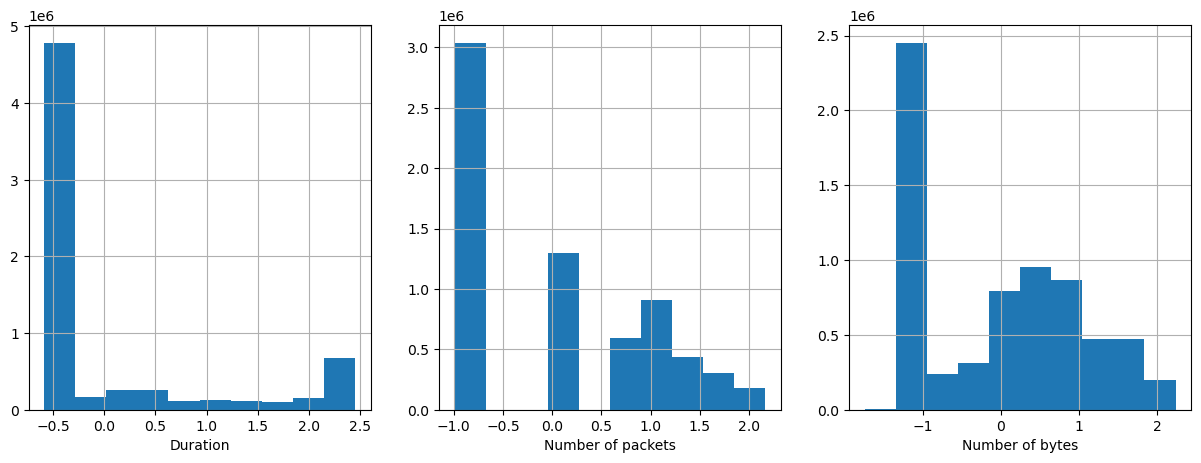

In [72]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df_train['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df_train['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
df_train['Bytes'].hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

In [79]:
# 정형 데이터를 그래프 데이터셋 형태로 변환해야 한다...

BATCH_SIZE = 16
features_host = [f'ipsrc_{i}' for i in range(1,17)] + [f'ipdst_{i}' for i in range(1,17)]
features_flow =  ['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Duration'
,             'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']

In [85]:
def get_connections(ip_map,src_ip,dst_ip):
    src1 = [ip_map[ip] for ip in src_ip]
    src2 = [ip_map[ip] for ip in dst_ip]
    src = np.column_stack((src1,src2)).flatten() # 노드 정보

    dst = list(range(len(src_ip)))
    dst = np.column_stack((dst,dst)).flatten() # 흐름 정보

    return torch.Tensor([src,dst]).int(),torch.Tensor([dst,src]).int() #역으로도 지정을 해서 업데이트

In [ ]:
# 데이터 로더 생성 함수 (용량이 커서 서브그래프로 분할)
def create_dataloader(df,subgraph_size=1024):
    n_subgraph = len(df) // subgraph_size

    for i in range(1,n_subgraph+1):
        subgraph = df[(i-1)*subgraph_size:i*subgraph_size] # 1024개씩 구분
        src_ip = subgraph['Src IP Addr'].to_numpy()
        dst_ip = subgraph['Dst IP Addr'].to_numpy()

        ip_map = {ip:index for index,ip in enumerate(np.unique(np.append(src_ip,dst_ip)))} # 덧셈쓰면 안됨!!!!(넘파이 어레이는 확장이 아닌 덧셈임)

        host_to_flow, flow_to_host = get_connections(ip_map,src_ip,dst_ip)
        


[ 8 10 12 14]
